In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from algorithms import fixed_bitwidth
from model_gen import keras_cnn
from algorithms.ind_optimized_search import IndependentOptimizedSearch

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
# longer/larger network
input_shape = (28, 28, 1)
num_outputs = 10
num_kernels = 32
num_stages = 7
path_trained_weights = 'C:/Users/320060820/experiments/test_models/mnist_custom/mnist_seq_large_w.h5'
name = 'mnist_seq_large'

from test_models.mnist_custom import data
_, test_data = data.get_data()

model_arch = keras_cnn.KerasCNNLarge(input_shape, num_outputs, num_kernels, num_stages, pool_layer_interval = 2, 
                                     path_trained_weights = path_trained_weights)
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]
print(float_model_acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0.995


In [3]:
model_obj.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        9248      
__________

### Weights

In [3]:
layer_names = []

for layer in model_obj.model.layers:
    if layer.name.startswith('conv2d') or layer.name.startswith('dense'):
        layer_names.append(layer.name)

In [5]:
# weights
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
w_scores, opt_params_weights, acc_drop_w = opts.run('weights', start_bw = 8)
opt_params_weights

{'conv2d_1': [8, 9], 'conv2d_2': [8, 9], 'conv2d_3': [8, 9], 'conv2d_4': [8, 9], 'conv2d_5': [8, 9], 'conv2d_6': [8, 9], 'conv2d_7': [8, 10], 'conv2d_8': [8, 10], 'conv2d_9': [8, 10], 'conv2d_10': [8, 10], 'conv2d_11': [8, 10], 'conv2d_12': [8, 10], 'conv2d_13': [8, 9], 'conv2d_14': [8, 9], 'dense_1': [8, 8]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (4, 5) Local opt: (5, 6) Performance diff: 0.001106
Chosen:  (4, 5)
After quantizing layer conv2d_1 | Measured accuracy drop 0.000704 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_2
Global opt: (3, 5) Local opt: (3, 5) Performance diff: 0.000000
Chosen:  (3, 5)
After quantizing layer conv2d_2 | Measured accuracy drop 0.000402 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_3
Global opt: (2, 3) Local opt: (2, 3) Performance diff: 0.000000
Chosen:  (2, 3)
After quantizing layer conv2d_3 | Measured accuracy drop 0.000905 | Acceptable accuracy drop: 0.003

{'conv2d_1': (4, 5),
 'conv2d_2': (3, 5),
 'conv2d_3': (2, 3),
 'conv2d_4': (3, 4),
 'conv2d_5': (2, 3),
 'conv2d_6': (2, 3),
 'conv2d_7': (3, 5),
 'conv2d_8': (2, 4),
 'conv2d_9': (2, 4),
 'conv2d_10': (2, 4),
 'conv2d_11': (2, 4),
 'conv2d_12': (2, 4),
 'conv2d_13': (2, 3),
 'conv2d_14': (2, 4),
 'dense_1': (2, 2)}

Floating point model accuracy: 99.500 %
Quantized model accuracy: 87.070 %
Accuracy drop of 12.492 %


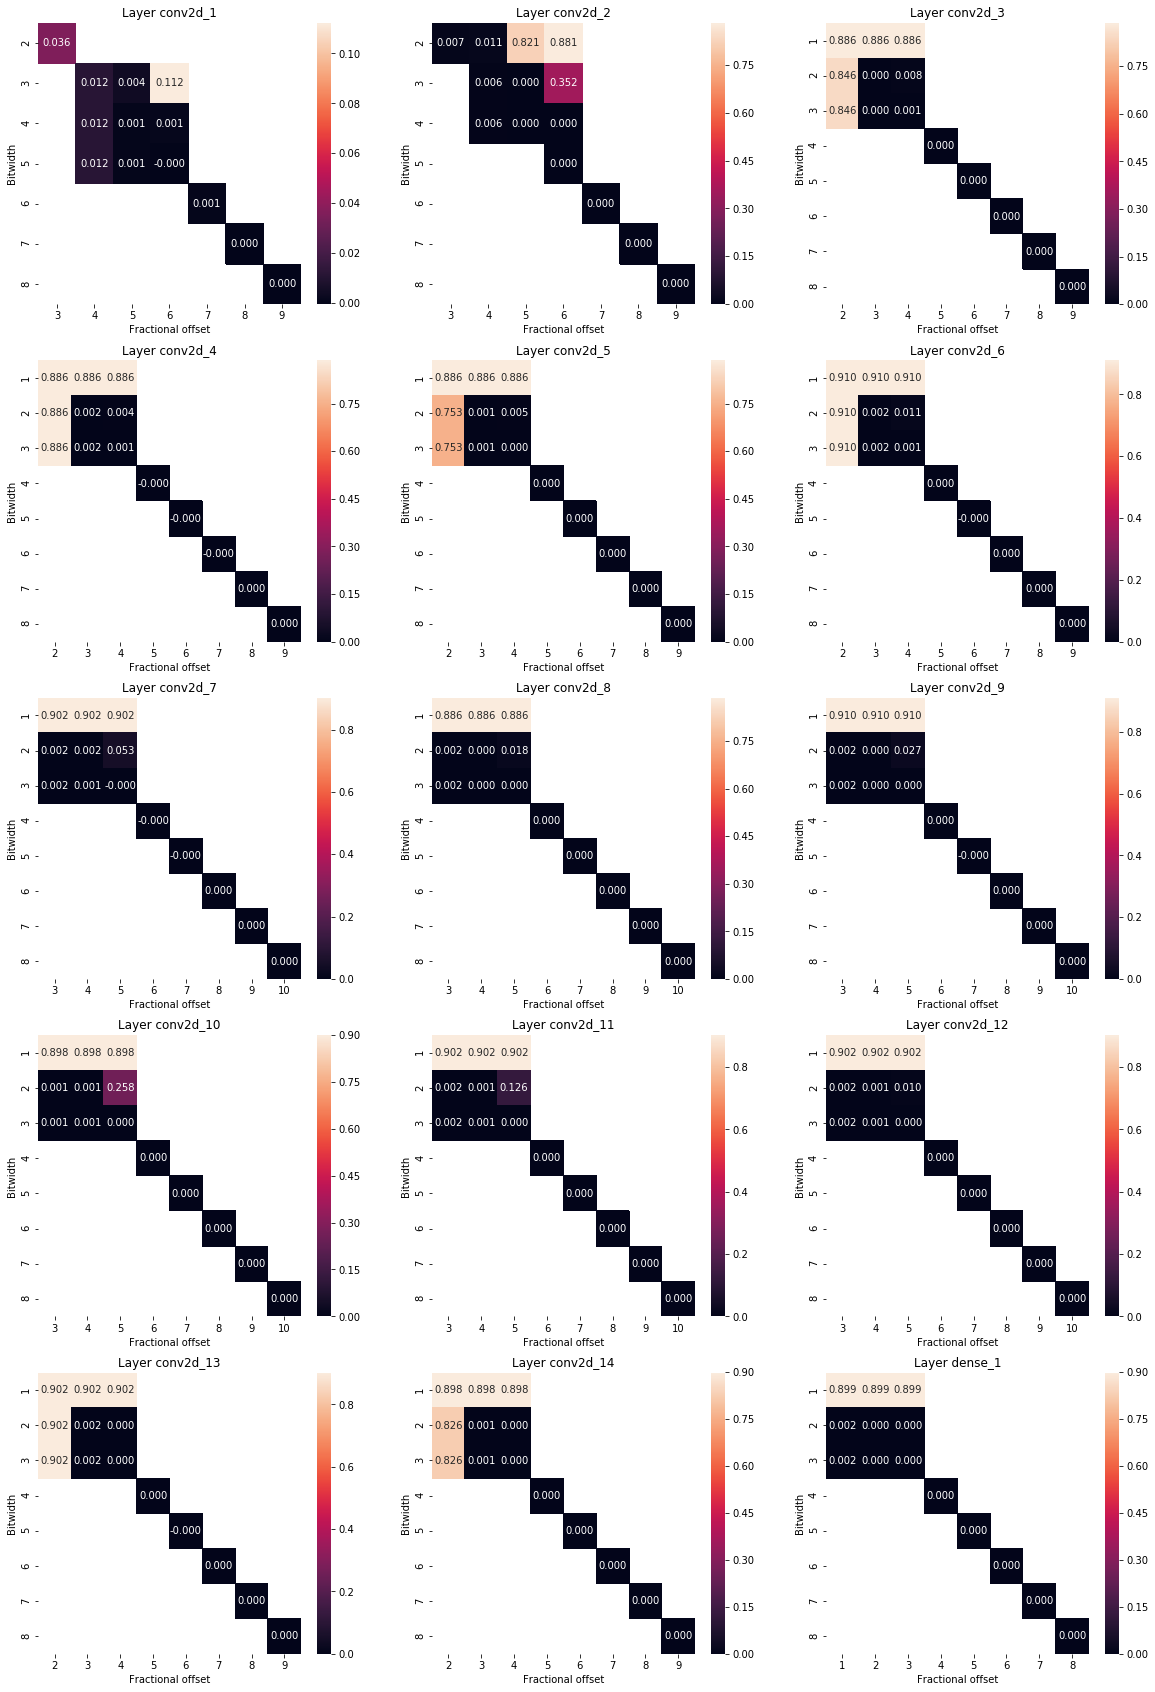

In [6]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights)
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(w_scores, 5, 3, (20, 30))

In [7]:
for layer in w_scores:
    print(layer)
    print(f'Layer {layer} acc drop: {w_scores[layer][opt_params_weights[layer][0]][opt_params_weights[layer][1]]:.5f}')

conv2d_1
Layer conv2d_1 acc drop: 0.00070
conv2d_2
Layer conv2d_2 acc drop: 0.00010
conv2d_3
Layer conv2d_3 acc drop: 0.00040
conv2d_4
Layer conv2d_4 acc drop: 0.00050
conv2d_5
Layer conv2d_5 acc drop: 0.00080
conv2d_6
Layer conv2d_6 acc drop: 0.00151
conv2d_7
Layer conv2d_7 acc drop: -0.00010
conv2d_8
Layer conv2d_8 acc drop: 0.00020
conv2d_9
Layer conv2d_9 acc drop: 0.00000
conv2d_10
Layer conv2d_10 acc drop: 0.00060
conv2d_11
Layer conv2d_11 acc drop: 0.00090
conv2d_12
Layer conv2d_12 acc drop: 0.00050
conv2d_13
Layer conv2d_13 acc drop: 0.00171
conv2d_14
Layer conv2d_14 acc drop: 0.00020
dense_1
Layer dense_1 acc drop: 0.00020


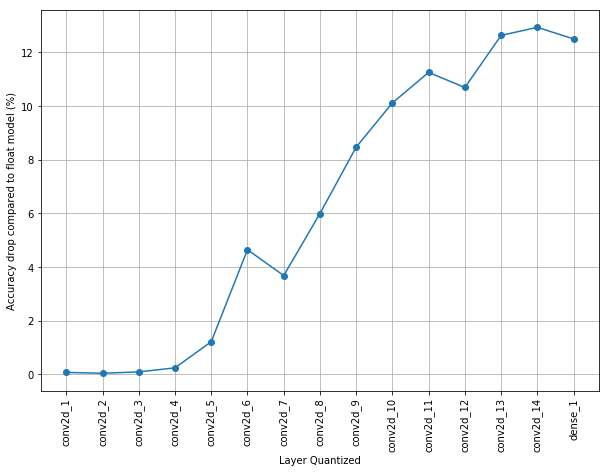

In [11]:
x = np.arange(1, len(acc_drop_w.values()) + 1, 1)
y = np.array(list(acc_drop_w.values())) * 100
labels = list(acc_drop_w.keys())

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-');
plt.xlabel('Layer Quantized')
plt.ylabel('Accuracy drop compared to float model (%)')
plt.xticks(x, labels, rotation='vertical');
plt.grid()

In [12]:
import pickle

save_path = 'C:/Users/320060820/experiments/outputs/Independent_Optimized_Search/Keras MNIST/'

with open(save_path + 'scores_w.p', 'wb') as f:
    pickle.dump(w_scores, f)
with open(save_path + 'opt_params_w.p', 'wb') as f:
    pickle.dump(opt_params_weights, f)
with open(save_path + 'acc_drop_w.p', 'wb') as f:
    pickle.dump(acc_drop_w, f)

### Biases

In [5]:
# biases
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
b_scores, opt_params_biases, acc_drop_b = opts.run('biases', start_bw = 8)
opt_params_biases

{'conv2d_1': [8, 12], 'conv2d_2': [8, 12], 'conv2d_3': [8, 12], 'conv2d_4': [8, 11], 'conv2d_5': [8, 11], 'conv2d_6': [8, 11], 'conv2d_7': [8, 11], 'conv2d_8': [8, 11], 'conv2d_9': [8, 11], 'conv2d_10': [8, 11], 'conv2d_11': [8, 11], 'conv2d_12': [8, 11], 'conv2d_13': [8, 11], 'conv2d_14': [8, 10], 'dense_1': [8, 10]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (1, 5) Local opt: (2, 6) Performance diff: 0.001809
Chosen:  (2, 6)
After quantizing layer conv2d_1 | Measured accuracy drop 0.001106 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_2
Global opt: (1, 5) Local opt: (1, 4) Performance diff: 0.000000
Chosen:  (1, 4)
After quantizing layer conv2d_2 | Measured accuracy drop 0.001106 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_3
Global opt: (1, 5) Local opt: (1, 4) Performance diff: 0.000000
Chosen:  (1, 4)
After quantizing layer conv2d_3 | Measured accuracy drop 0.001005 | Acceptable accuracy dr

{'conv2d_1': (2, 6),
 'conv2d_2': (1, 4),
 'conv2d_3': (1, 4),
 'conv2d_4': (1, 3),
 'conv2d_5': (1, 3),
 'conv2d_6': (1, 3),
 'conv2d_7': (1, 3),
 'conv2d_8': (1, 3),
 'conv2d_9': (1, 3),
 'conv2d_10': (1, 3),
 'conv2d_11': (1, 4),
 'conv2d_12': (1, 3),
 'conv2d_13': (1, 3),
 'conv2d_14': (1, 3),
 'dense_1': (1, 2)}

Floating point model accuracy: 99.500 %
Quantized model accuracy: 99.380 %
Accuracy drop of 0.121 %


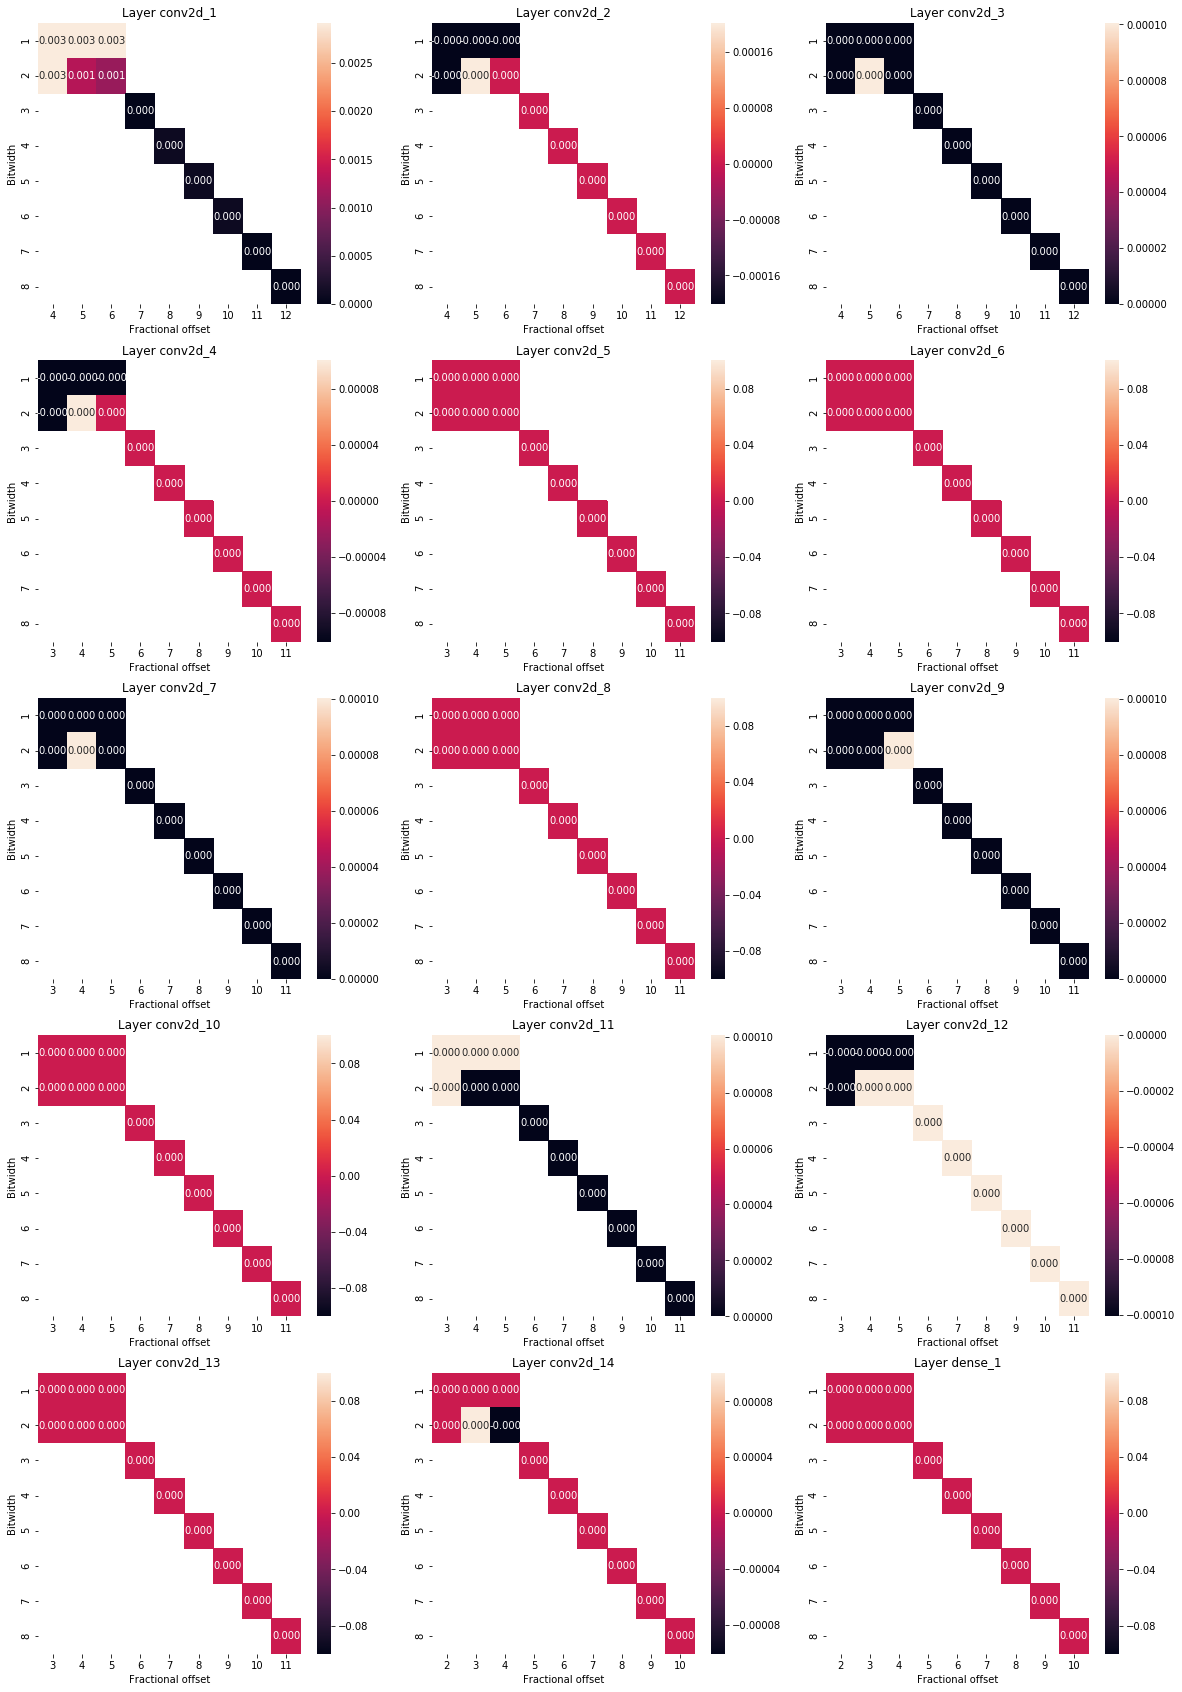

In [6]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
model_obj = fxp_quantize.fix_biases_quantization(model_obj, opt_params_biases)
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(b_scores, 5, 3, (20, 30))

In [7]:
for layer in b_scores:
    print(f'Layer {layer} acc drop: {b_scores[layer][opt_params_biases[layer][0]][opt_params_biases[layer][1]]:.5f}')

Layer conv2d_1 acc drop: 0.00111
Layer conv2d_2 acc drop: -0.00020
Layer conv2d_3 acc drop: 0.00000
Layer conv2d_4 acc drop: -0.00010
Layer conv2d_5 acc drop: 0.00000
Layer conv2d_6 acc drop: 0.00000
Layer conv2d_7 acc drop: 0.00000
Layer conv2d_8 acc drop: 0.00000
Layer conv2d_9 acc drop: 0.00000
Layer conv2d_10 acc drop: 0.00000
Layer conv2d_11 acc drop: 0.00010
Layer conv2d_12 acc drop: -0.00010
Layer conv2d_13 acc drop: 0.00000
Layer conv2d_14 acc drop: 0.00000
Layer dense_1 acc drop: 0.00000


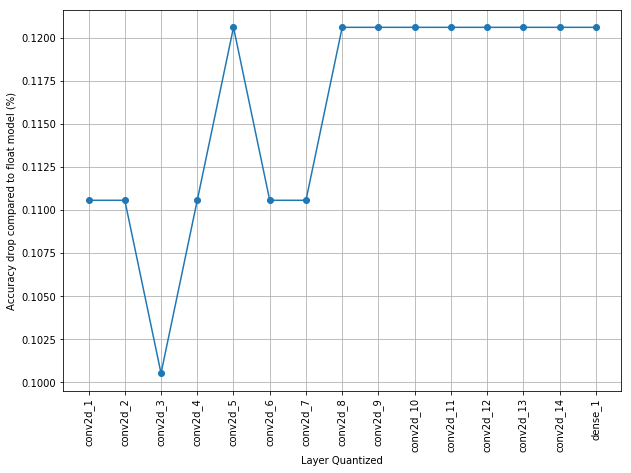

In [8]:
x = np.arange(1, len(acc_drop_b.values()) + 1, 1)
y = np.array(list(acc_drop_b.values())) * 100
labels = list(acc_drop_b.keys())

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-');
plt.xlabel('Layer Quantized')
plt.ylabel('Accuracy drop compared to float model (%)')
plt.xticks(x, labels, rotation='vertical');
plt.grid()

### Activations

In [9]:
# activations
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
a_scores, opt_params_act, acc_drop_a = opts.run('activations', start_bw = 8)
opt_params_act

{'conv2d_1': [8, 7], 'conv2d_2': [8, 4], 'conv2d_3': [8, 3], 'conv2d_4': [8, 3], 'conv2d_5': [8, 3], 'conv2d_6': [8, 3], 'conv2d_7': [8, 4], 'conv2d_8': [8, 3], 'conv2d_9': [8, 3], 'conv2d_10': [8, 3], 'conv2d_11': [8, 3], 'conv2d_12': [8, 3], 'conv2d_13': [8, 3], 'conv2d_14': [8, 3], 'dense_1': [8, 2]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (4, 5) Local opt: (5, 6) Performance diff: 0.001005
Chosen:  (4, 5)
After quantizing layer conv2d_1 | Measured accuracy drop 0.002412 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_2
Global opt: (4, 1) Local opt: (5, 2) Performance diff: 0.000603
Chosen:  (4, 1)
After quantizing layer conv2d_2 | Measured accuracy drop 0.009950 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_3
Global opt: (4, 1) Local opt: (4, 1) Performance diff: 0.000000
Chosen:  (4, 1)
After quantizing layer conv2d_3 | Measured accuracy drop 0.014472 | Acceptable accuracy drop: 0.003000
Qu

{'conv2d_1': (4, 5),
 'conv2d_2': (4, 1),
 'conv2d_3': (4, 1),
 'conv2d_4': (3, -1),
 'conv2d_5': (4, -1),
 'conv2d_6': (3, -1),
 'conv2d_7': (3, 0),
 'conv2d_8': (3, -1),
 'conv2d_9': (3, -1),
 'conv2d_10': (3, -1),
 'conv2d_11': (3, -1),
 'conv2d_12': (2, -1),
 'conv2d_13': (2, -2),
 'conv2d_14': (2, -1),
 'dense_1': (3, -2)}

Floating point model accuracy: 99.500 %
Quantized model accuracy: 91.950 %
Accuracy drop of 7.588 %


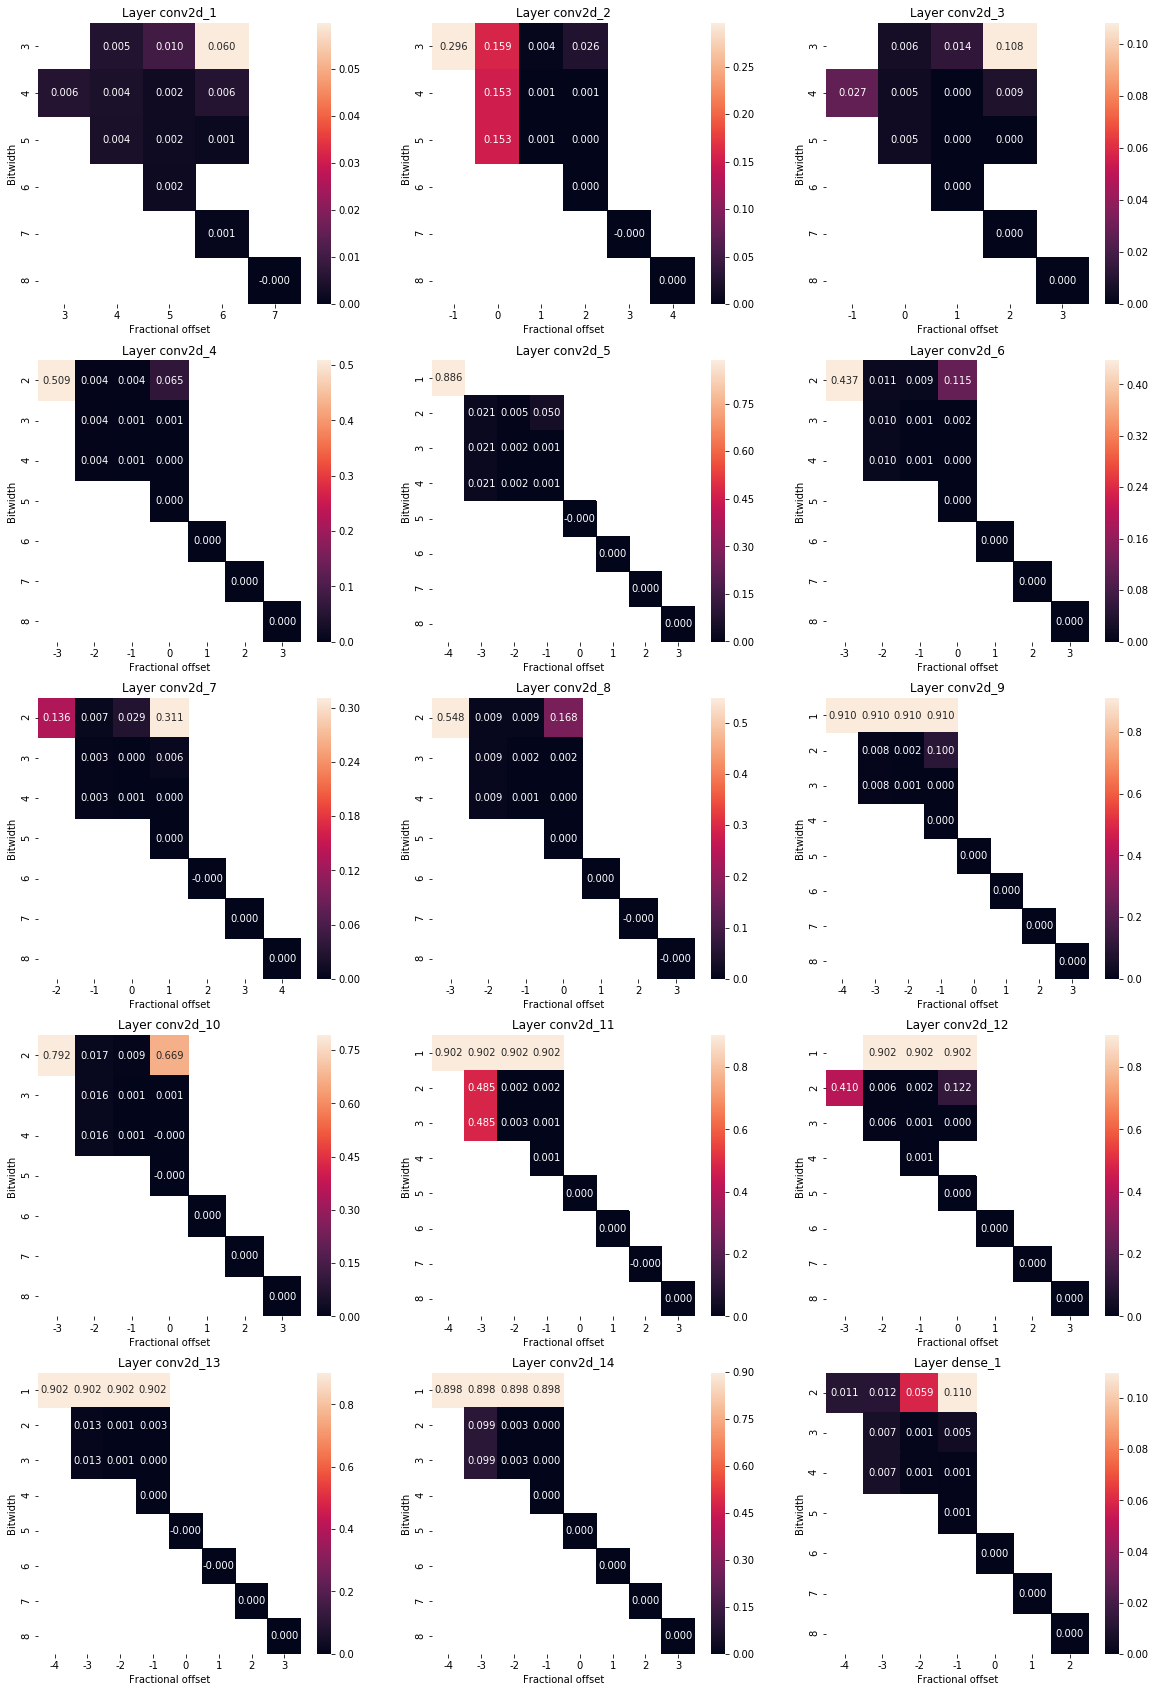

In [10]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act))
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(a_scores, 5, 3, (20, 30))

In [11]:
for layer in a_scores:
    print(f'Layer {layer} acc drop: {a_scores[layer][opt_params_act[layer][0]][opt_params_act[layer][1]]:.5f}')

Layer conv2d_1 acc drop: 0.00241
Layer conv2d_2 acc drop: 0.00080
Layer conv2d_3 acc drop: 0.00020
Layer conv2d_4 acc drop: 0.00060
Layer conv2d_5 acc drop: 0.00060
Layer conv2d_6 acc drop: 0.00060
Layer conv2d_7 acc drop: 0.00040
Layer conv2d_8 acc drop: 0.00151
Layer conv2d_9 acc drop: 0.00010
Layer conv2d_10 acc drop: 0.00131
Layer conv2d_11 acc drop: 0.00070
Layer conv2d_12 acc drop: 0.00161
Layer conv2d_13 acc drop: 0.00060
Layer conv2d_14 acc drop: 0.00040
Layer dense_1 acc drop: 0.00131


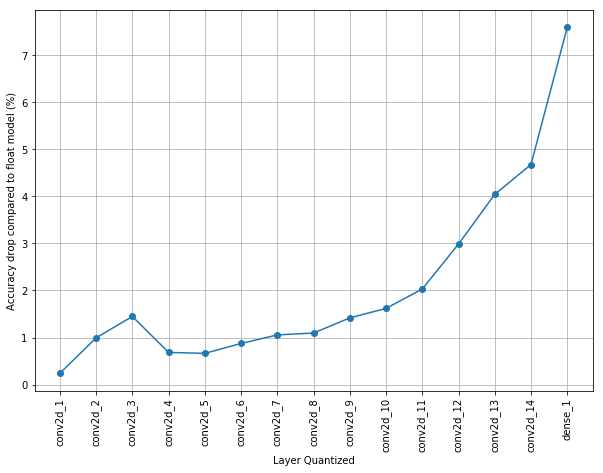

In [12]:
x = np.arange(1, len(acc_drop_a.values()) + 1, 1)
y = np.array(list(acc_drop_a.values())) * 100
labels = list(acc_drop_a.keys())

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-');
plt.xlabel('Layer Quantized')
plt.ylabel('Accuracy drop compared to float model (%)')
plt.xticks(x, labels, rotation='vertical');
plt.grid()

In [4]:
import pickle
save_path = 'C:/Users/320060820/experiments/outputs/Independent_Optimized_Search/Keras MNIST/'

In [5]:
with open(save_path + 'opt_params_w.p', 'rb') as f:
    opt_params_weights = pickle.load(f)
with open(save_path + 'opt_params_b.p', 'rb') as f:
    opt_params_biases = pickle.load(f)
with open(save_path + 'opt_params_a.p', 'rb') as f:
    opt_params_act = pickle.load(f)

In [6]:
def quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params={}, a_quant_params={}):
    
    if a_quant_params:
        model_obj = model_data.Model('name', test_data, model=model_arch.get_fxp_model(a_quant_params))
    else:
        model_obj = model_data.Model('name', test_data, model=model_arch.get_float_model())
    
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, w_quant_params)
    if b_quant_params:
        model_obj = fxp_quantize.fix_biases_quantization(model_obj, b_quant_params)
    
    return (float_model_acc - model_obj.evaluate_accuracy()[1]) / float_model_acc

def evaluate_seq_quant_performance(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params, a_quant_params):
    
    acc_drop_b = {}
    for i in range(1, len(list(b_quant_params.keys())) + 1):
        test_case = dict(itertools.islice(b_quant_params.items(), i))
        a = quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, test_case)
        acc_drop_b[list(test_case.keys())[-1]] = a
        print(acc_drop_b)

    acc_drop_a = {}
    for i in range(1, len(list(a_quant_params.keys())) + 1):
        test_case = dict(itertools.islice(a_quant_params.items(), i))
        a = quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params, test_case)
        acc_drop_a[list(test_case.keys())[-1]] = a
        print(acc_drop_a)
        
    return acc_drop_b, acc_drop_a  

In [10]:
def evaluate_seq_quant_performance2(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params, a_quant_params):
    
    acc_drop_a = {}
    for i in range(1, len(list(a_quant_params.keys())) + 1):
        test_case = dict(itertools.islice(a_quant_params.items(), i))
        a = quantize_evaluate(model_arch, test_data, float_model_acc, {}, {}, test_case)
        acc_drop_a[list(test_case.keys())[-1]] = a
        print(acc_drop_a)
    
    acc_drop_w = {}
    for i in range(1, len(list(w_quant_params.keys())) + 1):
        test_case = dict(itertools.islice(w_quant_params.items(), i))
        a = quantize_evaluate(model_arch, test_data, float_model_acc, test_case, {}, a_quant_params)
        acc_drop_w[list(test_case.keys())[-1]] = a
        print(acc_drop_w)

    acc_drop_b = {}
    for i in range(1, len(list(b_quant_params.keys())) + 1):
        test_case = dict(itertools.islice(b_quant_params.items(), i))
        a = quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, test_case, a_quant_params)
        acc_drop_b[list(test_case.keys())[-1]] = a
        print(acc_drop_b)

    return acc_drop_w, acc_drop_b, acc_drop_a

In [22]:
acc_drop_b, acc_drop_a = evaluate_seq_quant_performance(model_arch, test_data, float_model_acc, opt_params_weights, 
                                            opt_params_biases,
                                            opt_params_act)

{'conv2d_1': 0.08592964824120605}
{'conv2d_1': 0.08592964824120605, 'conv2d_2': 0.08462311557788939}
{'conv2d_1': 0.08592964824120605, 'conv2d_2': 0.08462311557788939, 'conv2d_3': 0.08783919597989953}
{'conv2d_1': 0.08592964824120605, 'conv2d_2': 0.08462311557788939, 'conv2d_3': 0.08783919597989953, 'conv2d_4': 0.09276381909547744}
{'conv2d_1': 0.08592964824120605, 'conv2d_2': 0.08462311557788939, 'conv2d_3': 0.08783919597989953, 'conv2d_4': 0.09276381909547744, 'conv2d_5': 0.0941708542713568}
{'conv2d_1': 0.08592964824120605, 'conv2d_2': 0.08462311557788939, 'conv2d_3': 0.08783919597989953, 'conv2d_4': 0.09276381909547744, 'conv2d_5': 0.0941708542713568, 'conv2d_6': 0.09597989949748746}
{'conv2d_1': 0.08592964824120605, 'conv2d_2': 0.08462311557788939, 'conv2d_3': 0.08783919597989953, 'conv2d_4': 0.09276381909547744, 'conv2d_5': 0.0941708542713568, 'conv2d_6': 0.09597989949748746, 'conv2d_7': 0.09778894472361803}
{'conv2d_1': 0.08592964824120605, 'conv2d_2': 0.08462311557788939, 'conv

In [11]:
acc_drop_w, acc_drop_b, acc_drop_a = evaluate_seq_quant_performance2(model_arch, test_data, float_model_acc, opt_params_weights, 
                                            opt_params_biases,
                                            opt_params_act)

{'conv2d_1': 0.0024120603015074953}
{'conv2d_1': 0.0024120603015074953, 'conv2d_2': 0.009949748743718612}
{'conv2d_1': 0.0024120603015074953, 'conv2d_2': 0.009949748743718612, 'conv2d_3': 0.014472361809045195}
{'conv2d_1': 0.0024120603015074953, 'conv2d_2': 0.009949748743718612, 'conv2d_3': 0.014472361809045195, 'conv2d_4': 0.006834170854271385}
{'conv2d_1': 0.0024120603015074953, 'conv2d_2': 0.009949748743718612, 'conv2d_3': 0.014472361809045195, 'conv2d_4': 0.006834170854271385, 'conv2d_5': 0.006633165829145779}
{'conv2d_1': 0.0024120603015074953, 'conv2d_2': 0.009949748743718612, 'conv2d_3': 0.014472361809045195, 'conv2d_4': 0.006834170854271385, 'conv2d_5': 0.006633165829145779, 'conv2d_6': 0.008743718592964866}
{'conv2d_1': 0.0024120603015074953, 'conv2d_2': 0.009949748743718612, 'conv2d_3': 0.014472361809045195, 'conv2d_4': 0.006834170854271385, 'conv2d_5': 0.006633165829145779, 'conv2d_6': 0.008743718592964866, 'conv2d_7': 0.010552763819095432}
{'conv2d_1': 0.0024120603015074953

{'conv2d_1': 0.46723618090452257, 'conv2d_2': 0.5014070351758794, 'conv2d_3': 0.5032160804020099, 'conv2d_4': 0.48844221105527635}
{'conv2d_1': 0.46723618090452257, 'conv2d_2': 0.5014070351758794, 'conv2d_3': 0.5032160804020099, 'conv2d_4': 0.48844221105527635, 'conv2d_5': 0.4888442211055276}
{'conv2d_1': 0.46723618090452257, 'conv2d_2': 0.5014070351758794, 'conv2d_3': 0.5032160804020099, 'conv2d_4': 0.48844221105527635, 'conv2d_5': 0.4888442211055276, 'conv2d_6': 0.49175879396984923}
{'conv2d_1': 0.46723618090452257, 'conv2d_2': 0.5014070351758794, 'conv2d_3': 0.5032160804020099, 'conv2d_4': 0.48844221105527635, 'conv2d_5': 0.4888442211055276, 'conv2d_6': 0.49175879396984923, 'conv2d_7': 0.4890452261306533}
{'conv2d_1': 0.46723618090452257, 'conv2d_2': 0.5014070351758794, 'conv2d_3': 0.5032160804020099, 'conv2d_4': 0.48844221105527635, 'conv2d_5': 0.4888442211055276, 'conv2d_6': 0.49175879396984923, 'conv2d_7': 0.4890452261306533, 'conv2d_8': 0.5013065326633166}
{'conv2d_1': 0.4672361

In [12]:
acc_drop = {'weights': acc_drop_w, 'biases': acc_drop_b, 'activations': acc_drop_a}

In [19]:
def plot_seq_acc_drop(acc_drop):
    
    plt.rcParams.update({'font.size': 12, 'font.weight':520})
#     if model.startswith('Keras'):
    plt.figure(figsize=(12, 9))
#     else:
#         plt.figure(figsize=(15, 7))
    
    x = np.arange(1, len(list(acc_drop['weights'].keys())) + 1, 1)
    for j, k in enumerate(['activations', 'weights', 'biases']):
        y = np.array(list(acc_drop[k].values())) * 100
        plt.plot(x, y, 'o-', label=k + ' (' + str(j + 1) + ')')
    plt.grid(b=True)
    plt.legend()
    layer_names = list(acc_drop['weights'].keys())
    layer_names = ['C_{}'.format(x.split('_')[1]) if x.startswith('conv') else 'D_1' for x in layer_names ]
    plt.xticks(x, layer_names, rotation='vertical')
    plt.xlabel('Layer name')
    plt.ylabel('Measured Inference Accuracy Loss (%)')
#     model = model.split(' ')[0] + '_' + model.split(' ')[1]
#     plt.savefig('C:/Users/320060820/OneDrive - Philips/Thesis docs/Thesis/Images/Independent quantization/' \
#                 + 'ind_seq_acc_loss_' + model + '.png', bbox_inches='tight')

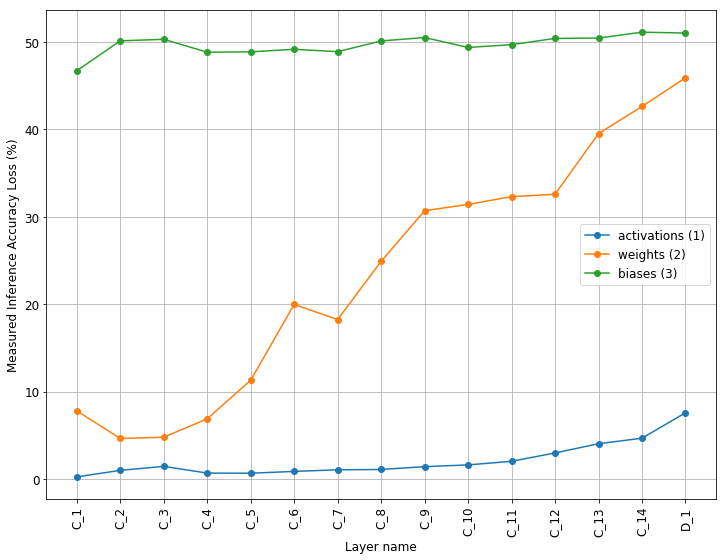

In [20]:
plot_seq_acc_drop(acc_drop)

In [23]:
with open(save_path + 'scores_b.p', 'wb') as f:
    pickle.dump(b_scores, f)
with open(save_path + 'opt_params_b.p', 'wb') as f:
    pickle.dump(opt_params_biases, f)
with open(save_path + 'acc_drop_b.p', 'wb') as f:
    pickle.dump(acc_drop_b, f)

In [24]:
import pickle

save_path = 'C:/Users/320060820/experiments/outputs/Independent_Optimized_Search/Keras MNIST/'

with open(save_path + 'scores_a.p', 'wb') as f:
    pickle.dump(a_scores, f)
with open(save_path + 'opt_params_a.p', 'wb') as f:
    pickle.dump(opt_params_act, f)
with open(save_path + 'acc_drop_a.p', 'wb') as f:
    pickle.dump(acc_drop_a, f)